# Алгоритмы анализа данных
## Урок 8. Снижение размерности данных

### Задача 1

Можно ли отобрать наиболее значимые признаки с помощью PCA?

**Решение**

Нет, так как PCA уменьшает размерность пространства путём его разворота, а не отбором наиболее важных признаков.

### Задача 2*

Примите участие в одном или двух соревнованиях и пришлите свой псевдоним на Kaggle и ссылку на github с решением соревнования:
* по регрессии (https://www.kaggle.com/c/tutors-expected-math-exam-results)
* или классификации (https://www.kaggle.com/c/choose-tutors).

В скрипте можно использовать только эти импорты:
```import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
```

**Решение**

Просьба: добавьте, пожалуйста, в список разрешенных импортов модуль random, который необходим для бутсрепинга.

Псевдоним: Andrei Iatsuk (yatsukav)

В `regression.ipynb` удалось довольно легко при помощи градиентного бустинга и подбора гиперпараметров попасть в TOP 10.

В `classification.ipynb` самый лучший результат (0.59) я получил при классическом древе решений. Результат на случайном лесе оказался ниже (0.56), как при использовании критерия Джинни, так и при энтропии Шеннона. Реализация градиентного бустинга оказалась хуже всего (0.50) — я вам буду очень признателен за обратную связь по этому алгориму, не сделал ли я грубой ошибки при его реализации. К сожалению, все эти результаты оказались ниже необходимого порога (0.65).

### Задача 3*

Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции `numpy.linalg.svd()`.

**Решение**

In [1]:
import numpy as np

In [2]:
def pca_svd(X, n_elements):
    # Произведём сингулярное разложение
    U, s, W = np.linalg.svd(X)
    print('s:', s)
    V = W.T  # Транспонируем матрицу W
    # s - список диагональных элементов, его нужно привести к виду диагональной матрицы
    Sigma = np.zeros_like(X, dtype=float)
    Sigma[np.diag_indices(min(X.shape))] = s
    # Перестроим матрицу
    Sigma = Sigma[:,:n_elements]
    V = V[:,:n_elements]
    B = U @ (Sigma @ V.T)
    # Переведем новую матрицу в новое n_elements-мерное пространство
    U, s, W = np.linalg.svd(B)
    return (W @ B.T)[:n_elements].T

### Задача 4*

Обучить любую модель классификации на датасете iris до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

**Решение**

In [3]:
from sklearn import datasets, model_selection
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [4]:
def e_metrics(x1, x2):
    """ Функция для подсчета евклидовой метрики.
    """
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [5]:
def knn(x_train, y_train, x_test, k):
    """Алгоритм поиска k ближайших соседей.
    """
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        sorted_distances = sorted(test_distances)[0:k]
        k_dist_sum = sum([d[0] for d in sorted_distances])
        for d in sorted_distances:
            classes[d[1]] += 1 - d[0] / k_dist_sum
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [6]:
def get_graph(X_train, y_train, k):
    """График распределения классов.
    """
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

In [7]:
def accuracy(pred, y):
    """Функция для вычисления точности.
    """
    return (sum(pred == y) / len(y))

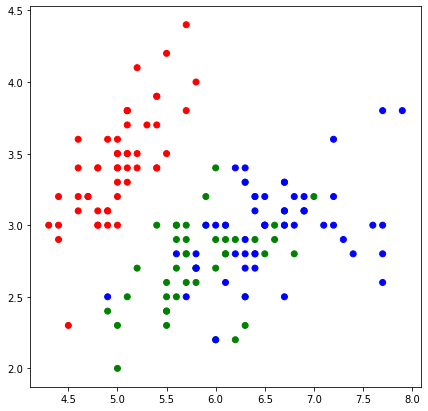

In [8]:
# Загрузим датасет из sklearn
X, y = datasets.load_iris(return_X_y=True)
X.shape

# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

# Визуализируем её
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
plt.show()

s: [95.95991387 17.76103366  3.46093093  1.88482631]


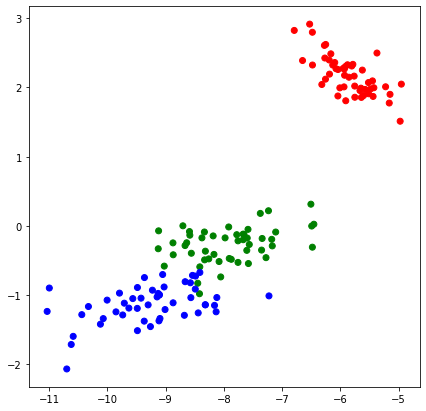

In [9]:
# Применим PCA
X_pca = pca_svd(X, 2)
X_pca.shape

# Разделим выборку на обучающую и тестовую
X_pca_train, X_pca_test, y_pca_train, y_pca_test = model_selection.train_test_split(X_pca, y, test_size=0.2, random_state=1)

# Визуализируем её
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=cmap)
plt.show()

In [10]:
# Зададим количество ближайших соседей k
k = 3

Точность алгоритма на обучающей выборке при k = 3: 0.983
Точность алгоритма на тестовой выборке при k = 3: 1.000


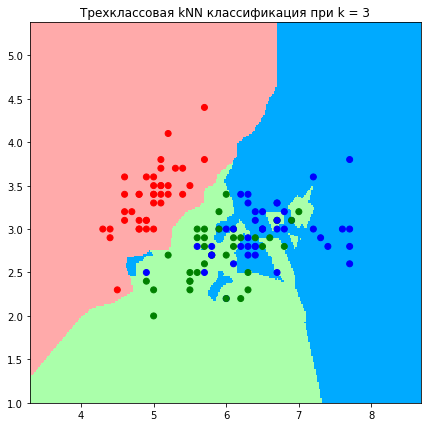

CPU times: user 42.4 s, sys: 82.1 ms, total: 42.5 s
Wall time: 42.5 s


In [11]:
%%time
# Обучим knn на 4 мерном пространстве
y_train_pred = knn(X_train, y_train, X_train, k)
print(f'Точность алгоритма на обучающей выборке при k = {k}: {accuracy(y_train_pred, y_train):.3f}')
y_pred = knn(X_train, y_train, X_test, k)
print(f'Точность алгоритма на тестовой выборке при k = {k}: {accuracy(y_pred, y_test):.3f}')
get_graph(X_train, y_train, k)

Точность алгоритма на обучающей выборке при k = 3: 0.992
Точность алгоритма на тестовой выборке при k = 3: 1.000


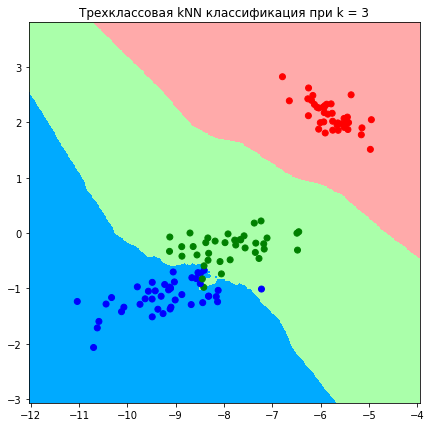

In [12]:
# Обучим knn на 2 мерном пространстве после PCA
y_pca_train_pred = knn(X_pca_train, y_pca_train, X_pca_train, k)
print(f'Точность алгоритма на обучающей выборке при k = {k}: {accuracy(y_pca_train_pred, y_pca_train):.3f}')
y_pca_pred = knn(X_pca_train, y_pca_train, X_pca_test, k)
print(f'Точность алгоритма на тестовой выборке при k = {k}: {accuracy(y_pca_pred, y_pca_test):.3f}')
get_graph(X_pca_train, y_pca_train, k)

Видим, что PCA не только не оказал существенного влияния на модель классификации, но и даже немного увеличил её точность. При этом визуально разделение пространства стало более сглаженным.